In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('cleaned_laptop_dataset.csv')

In [3]:
df.head()

,Brand,Price,Processor_Brand,RAM_Expandable,RAM_Size (GB),RAM_TYPE(DDR),Ghz,Display_type,GPU_Brand,SSD(GB),HDD(GB),Display_Tier,GPU_Tier,Processor_Tier,Processor_Speed(Ghz)
0,Lenovo,127011.5,AMD,Yes,8,4,4.000000,LCD,AMD,512.0,0,Large,Entry-level,Mid-End,4.0
1,Dell,274750.0,Intel,Yes,16,5,3.300000,LCD,NVIDIA,512.0,0,Large,Mid-end,Other,3.5
2,Hp,194215.0,Intel,Yes,8,4,4.200000,LCD,Intel,512.0,0,Large,Low-end,Other,4.0
3,Other,76965.0,Intel,No,8,4,1.700000,LCD,Intel,512.0,0,Large,Entry-level,Other,1.5
4,Acer,122465.0,Intel,Yes,16,4,2.738589,LCD,Intel,512.0,0,Small,Low-end,Other,2.5


In [4]:
le_dict = {}
for col in ['Brand', 'Processor_Brand', 'Display_type', 'GPU_Brand','GPU_Tier']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # store encoder if you need to inverse transform later

In [5]:
df['RAM_Expandable'] = df['RAM_Expandable'].map({'Yes': 1, 'No': 0})

In [6]:
processor_tier_map = {
    'Low-End': 1,
    'Mid-End': 2,
    'High-End': 3,
    'Apple M-Series': 4
}
df['Processor_Tier'] = df['Processor_Tier'].map(processor_tier_map)

In [7]:
# gpu_tier_map = {
#     'Entry-Level': 1,
#     'Low-End': 2,
#     'Mid-End': 3,
#     'High-End': 4
# }
# df['GPU_Tier'] = df['GPU_Tier'].map(gpu_tier_map)

In [8]:
display_map = {
    'Small': 1,
    'Medium': 2,
    'Large': 3
}

df['Display_Tier'] = df['Display_Tier'].map(display_map)

In [9]:
df.head()

,Brand,Price,Processor_Brand,RAM_Expandable,RAM_Size (GB),RAM_TYPE(DDR),Ghz,Display_type,GPU_Brand,SSD(GB),HDD(GB),Display_Tier,GPU_Tier,Processor_Tier,Processor_Speed(Ghz)
0,5,127011.5,0,1,8,4,4.000000,0,0,512.0,0,3,0,2.0,4.0
1,3,274750.0,2,1,16,5,3.300000,0,3,512.0,0,3,3,NaN,3.5
2,4,194215.0,2,1,8,4,4.200000,0,2,512.0,0,3,2,NaN,4.0
3,7,76965.0,2,0,8,4,1.700000,0,2,512.0,0,3,0,NaN,1.5
4,0,122465.0,2,1,16,4,2.738589,0,2,512.0,0,1,2,NaN,2.5


In [10]:
X = df.drop(columns=['Price'])
y = df['Price']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
xgb_model = XGBRegressor(
    n_estimators=5000,     # number of trees
    learning_rate=0.05,   # shrinkage step
    max_depth=8,          # tree depth
    subsample=0.8,        # row sampling
    colsample_bytree=0.8, # feature sampling
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,  # NEW: can pass here
    eval_metric='rmse'          # NEW: can pass here
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

print(f"Best iteration: {xgb_model.best_iteration}")

[0]	validation_0-rmse:169071.56329
[100]	validation_0-rmse:81767.35956
[173]	validation_0-rmse:81669.84639
Best iteration: 124


In [13]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 81026.61724592623
R² Score: 0.7840997040824927


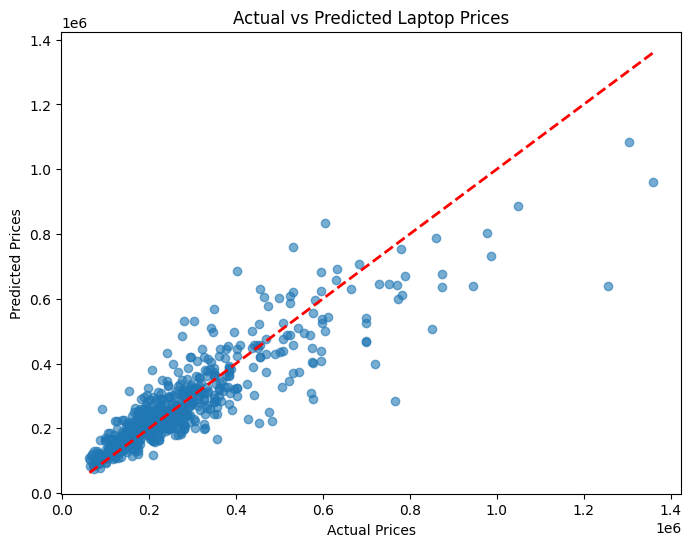

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()

In [ ]:
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3]
}


search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # take square root manually
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 81908.13933865285
R² Score: 0.7793764124782401


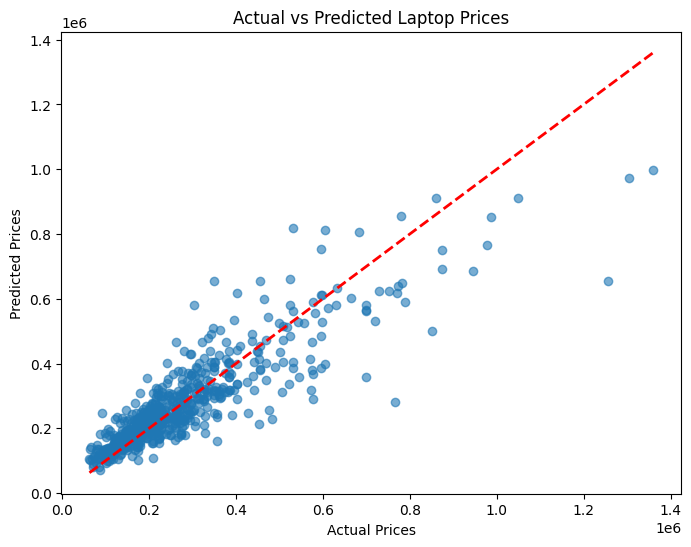

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()

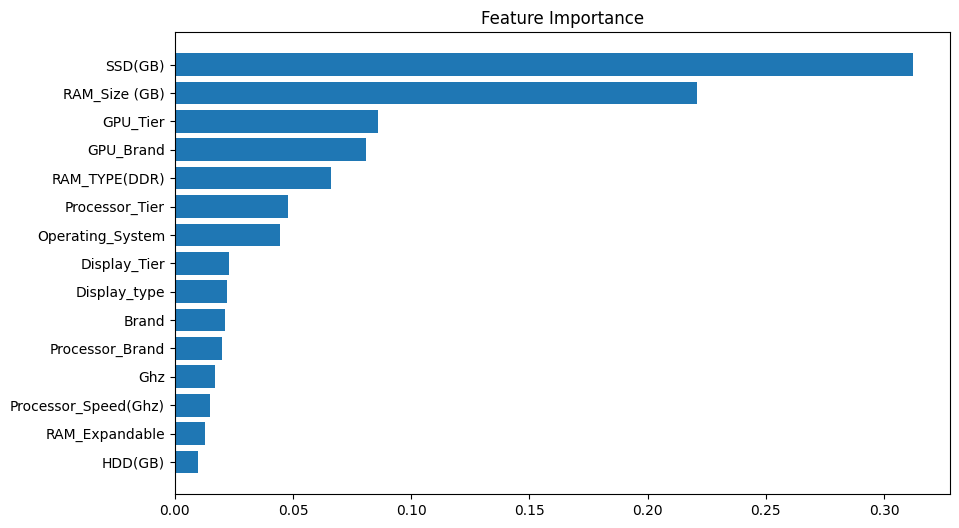

In [ ]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()


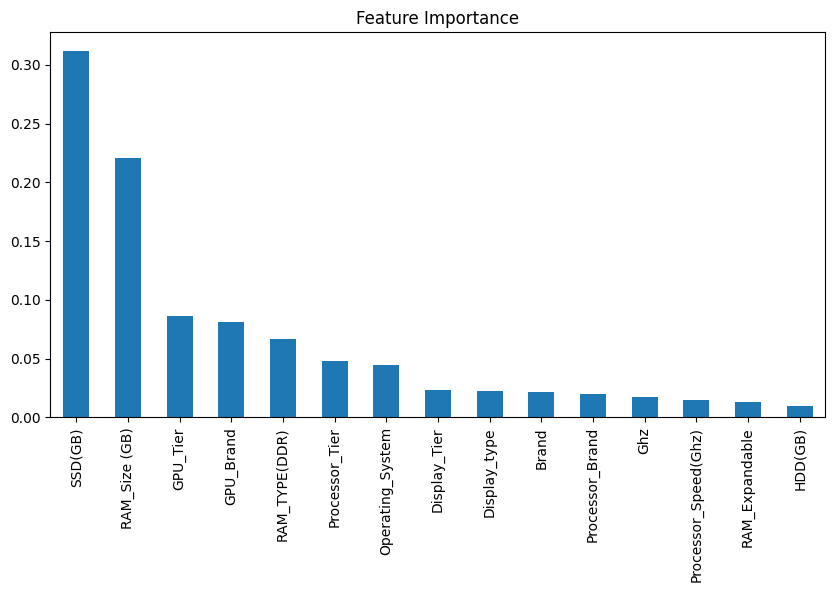

In [ ]:
importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance")
plt.show()

In [ ]:
import joblib

joblib.dump(best_model, "XgBoost_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
feature_names = X.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")
print(f"Feature names saved! Total features: {len(feature_names)}")

print("\nFeature columns:")
for i, col in enumerate(feature_names, 1):
    print(f"{i}. {col}")

Feature names saved! Total features: 15

Feature columns:
1. Brand
2. Processor_Brand
3. RAM_Expandable
4. RAM_Size (GB)
5. RAM_TYPE(DDR)
6. Ghz
7. Display_type
8. GPU_Brand
9. SSD(GB)
10. HDD(GB)
11. Operating_System
12. Display_Tier
13. GPU_Tier
14. Processor_Tier
15. Processor_Speed(Ghz)
